In [1]:
import pickle

with open('outputs/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('outputs/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)
        
with open('outputs/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_size=7, out_size=18):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(in_size, 16, num_layers=1)
        self.fc = nn.Linear(16, out_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        logits = self.fc(hn).reshape(-1)
        return logits

sample_input = torch.randn(64, 7)
Net(in_size=7, out_size=18)(sample_input)

tensor([ 0.0484,  0.2134,  0.0600,  0.0940,  0.2484, -0.2177, -0.2453, -0.1369,
        -0.3313,  0.0397, -0.0047, -0.0010,  0.2153,  0.1035, -0.0336, -0.0129,
         0.2543,  0.1832], grad_fn=<ViewBackward0>)

In [5]:
from pathlib import Path

model_weights = Path("outputs/lstm_weights.pth")
load_weights = False
if model_weights.exists():
    load_weights = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print("Device: ", device)


Device:  cuda:0


In [6]:
import torch.optim as optim

net = Net().to(device)

if not load_weights:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            optimizer.zero_grad()
            assert data['input'].isnan().any() == False
            logits = net(data["input"].to(device))
            loss = criterion(logits, data["target"].to(device))
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            
        print(f'Epoch: {epoch + 1:2d} loss: {running_loss / i:.3f}')
    
    print('Finished Training')
    torch.save(net.state_dict(), model_weights)

else:
    net.load_state_dict(torch.load(model_weights, weights_only=True))


net.eval()

Epoch:  1 loss: 2.544
Epoch:  2 loss: 2.366
Epoch:  3 loss: 2.267
Epoch:  4 loss: 2.210
Epoch:  5 loss: 2.146
Epoch:  6 loss: 2.086
Epoch:  7 loss: 2.057
Epoch:  8 loss: 2.051
Epoch:  9 loss: 2.017
Epoch: 10 loss: 1.970
Finished Training


Net(
  (lstm): LSTM(7, 16)
  (fc): Linear(in_features=16, out_features=18, bias=True)
)

In [7]:
preds, target = [], []
for data in train_data:
    preds.append(net(data['input'].to(device)).argmax().cpu())
    target.append(data['target'].argmax())

preds = torch.tensor(preds)
target = torch.tensor(target)

accuracy = lambda preds, target : (preds == target).sum() / len(preds)

In [8]:
import polars as pl

target = pl.Series(labels)[target.numpy()].to_numpy()
preds = pl.Series(labels)[preds.numpy()].to_numpy()

In [9]:
import numpy as np
np.unique(preds).shape, np.unique(target).shape

((18,), (18,))

                                            precision    recall  f1-score   support

                             Text on phone       0.67      0.76      0.71       640
                 Pull air toward your face       0.36      0.45      0.40       477
                       Eyelash - pull hair       0.20      0.16      0.18       640
                     Above ear - pull hair       0.26      0.28      0.27       638
                         Write name in air       0.29      0.36      0.32       477
                        Cheek - pinch skin       0.24      0.15      0.18       637
                       Pinch knee/leg skin       0.31      0.35      0.33       161
                     Drink from bottle/cup       0.55      0.50      0.53       161
                  Forehead - pull hairline       0.20      0.02      0.04       640
                        Forehead - scratch       0.28      0.57      0.37       640
Feel around in tray and pull out an object       0.58      0.52      0.55  

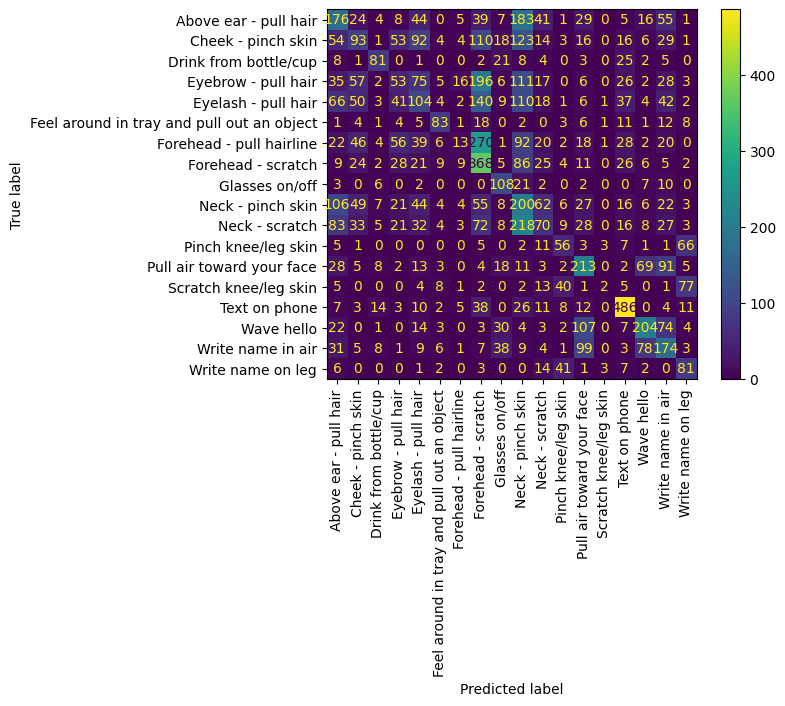

In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(target, preds, xticks_rotation='vertical')
report = classification_report(target, preds, labels=labels)
print(report)